<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/02_Exploratory_Data_Analysis/Topic_Modelling_LDA.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>

# Topic Modelling - Latent Dirichlet Allocation (LDA)

## 1. Introduction

Topic modelling is an unsupervised machine learning technique which uses a quantitative algorithm to abstract topics from a collection of documents. It is inductive, as opposed to clustering which is deductive and finds distinct groups of documents within a corpus.

In an earlier notebook we explored the vector-based Latent Semantic Analysis (LSA) approach by performing `TruncatedSVD()` on a TF-IDF matrix to decompose it into matrices for term-topics, topic importances and topic-documents, and identifying the most significant topics in the corpus.

Here we will consider Latent Dirichlet Allocation (LDA), a generative probabilistic approach in which topics are represented as the probability that each of a given set of terms will occur. Documents are represented by a mixture of topics that are present in the corpus in a certain proportion, and words may occur in multiple topics.

## 2. Install/import libraries

In [ ]:
!pip install spacy scispacy scikit-learn pyldavis gensim

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pickle
import tqdm

import spacy
import scispacy
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint

from spacy.lang.en import stop_words
from spacy.tokenizer import Tokenizer

## 3. Load data

In [ ]:
with open('2024-02-24_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.pickle', 'rb') as f:
    pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated = pickle.load(f)

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11687 entries, 0 to 11686
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     11687 non-null  object
 1   published      11687 non-null  object
 2   revised        11687 non-null  object
 3   title          11687 non-null  object
 4   title_cleaned  11687 non-null  object
 5   journal        11426 non-null  object
 6   authors        11687 non-null  object
 7   doi            11450 non-null  object
 8   pdf_url        11687 non-null  object
 9   text           11687 non-null  object
 10  word_count     11687 non-null  int64 
 11  sent_count     11687 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [ ]:
df = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.copy()

## 4. Preprocessing

The first step is to transform the raw text data for all the article titles into a suitable format for training the LDA model.



### 4.1 Stopwords and clean text

We will build a preprocessing pipeline using spaCy and regular expressions to handle stopwords and text cleaning.

In [ ]:
# load spacy model and disable unused components from pipeline

nlp = spacy.load('en_core_sci_sm', disable=['parser', 'ner'])

In [ ]:
# Custom stopwords and clean text

def preprocess_stop_words():
    stop = set(word.lower() for word in nlp.Defaults.stop_words)
    custom_stop_words = ["et", "al", "al.", "s"]
    for item in custom_stop_words:
        stop.add(item)
        nlp.vocab[item].is_stop = True
    stop.remove("in")
    return stop


def clean_text(text):
    pattern = re.compile(r"(?![0-9]+\b)[A-Za-z0-9\-α-ωΑ-Ω.]+")
    cleaned_text = " ".join(pattern.findall(text))
    return cleaned_text

In [ ]:
def preprocess_pipe(df):
    stop = preprocess_stop_words()

    # Apply cleaning and tokenisation to the text column
    df['title_preproc'] = df['title_cleaned'].apply(lambda x: " ".join([token.text.lower() for token in nlp(clean_text(x))
                                                         if token.text.lower() not in stop]))
    return df

In [ ]:
df = preprocess_pipe(df)

In [ ]:
with open('2024-03-07_pmc_arxiv_title_preproc.pickle', 'wb') as f:
  pickle.dump(df, f)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11687 entries, 0 to 11686
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     11687 non-null  object
 1   published      11687 non-null  object
 2   revised        11687 non-null  object
 3   title          11687 non-null  object
 4   title_cleaned  11687 non-null  object
 5   journal        11426 non-null  object
 6   authors        11687 non-null  object
 7   doi            11450 non-null  object
 8   pdf_url        11687 non-null  object
 9   text           11687 non-null  object
 10  word_count     11687 non-null  int64 
 11  sent_count     11687 non-null  int64 
 12  title_preproc  11687 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.2+ MB


In [ ]:
df.title_preproc[0]

'drug repositioning bibliometric analysis .'

### 4.2 Tokenisation

We will word tokenise the text and remove all punctuation appearing as a single token.

In [ ]:
# Convert dataframe to list

data = df.title_preproc.values.tolist()

In [ ]:
def word_tok_text(texts):
    data_words = []

    for doc in nlp.pipe(texts, batch_size=20):
        # Tokenise each document into words, excluding single-character punctuation tokens
        tokenized_words = [token.text.lower() for token in doc if not (token.is_punct and len(token.text.strip()) == 1)]
        data_words.append(tokenized_words)

    return data_words

In [ ]:
data_words = list(word_tok_text(data))

In [ ]:
data_words

[['drug', 'repositioning', 'bibliometric', 'analysis'],
 ['review',
  'computer-aided',
  'chemogenomics',
  'drug',
  'repositioning',
  'rational',
  'covid-19',
  'drug',
  'discovery'],
 ['repurposing', 'molnupiravir', 'new', 'opportunity', 'treat', 'covid-19'],
 ['scope',
  'repurposed',
  'drugs',
  'potential',
  'targets',
  'latest',
  'variants',
  'sars-cov-2'],
 ['drug',
  'repurposing',
  'gene',
  'co-expression',
  'module',
  'preservation',
  'analysis',
  'in',
  'acute',
  'respiratory',
  'distress',
  'syndrome',
  'ards',
  'systemic',
  'inflammatory',
  'response',
  'syndrome',
  'sirs',
  'sepsis',
  'covid-19'],
 ['novel',
  'drug',
  'design',
  'treatment',
  'covid-19',
  'systematic',
  'review',
  'preclinical',
  'studies'],
 ['repurposing',
  'fda-approved',
  'drugs',
  'cetilistat',
  'abiraterone',
  'diiodohydroxyquinoline',
  'bexarotene',
  'remdesivir',
  'potential',
  'inhibitors',
  'rna',
  'dependent',
  'rna',
  'polymerase',
  'sars-cov-2

In [ ]:
with open('2024-03-06_pmc_arxiv_titles_preproc_list_tok.pickle', 'wb') as f:
  pickle.dump(data_words, f)

## 5. Feature engineering

The [Gensim](https://radimrehurek.com/gensim/models/phrases.html) library will be used to automatically detect common phrases, or multi-word expressions and word n-gram collocations, from a text corpus.

### 5.1 Build bigram and trigram models

The `Phrases()` class detects phrases based on collocation counts.

The `sentences` parameter is the text corpus and accepts an iterable of a list of strings - here it is our list of word tokenised sentences.

The `min_count()` parameter ignores all words and bigrams with total collected count lower than this value.

The `threshold()` parameter represents a score threshold for forming the phrases (higher means fewer phrases).

The ability of these models to identify bigrams/trigrams is therefore inversely proportionate - as these parameters are set to higher values, the quantity of the bigrams/trigrams identified diminishes but the quality improves.

The `Phraser()` class then accepts the `phrases_model` as a parameter, or the trained phrases instance to extract all phrases from. Its goal is to cut down memory consumption of `Phrases()`, by discarding model state not strictly needed for the phrase detection task.

In [ ]:
# Build the bigram and trigram models
# https://radimrehurek.com/gensim/models/phrases.html
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=8) # higher means fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=8)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Print a few samples to compare output for bigrams and trigrams.

In [ ]:
print(bigram_mod[data_words[10]])

['recent', 'computational', 'drug_repositioning', 'strategies', 'sars-cov-2']


In [ ]:
print(trigram_mod[bigram_mod[data_words[10]]])

['recent', 'computational_drug_repositioning', 'strategies', 'sars-cov-2']


In [ ]:
print(bigram_mod[data_words[11]])

['computational_approach', 'drug_repurposing', 'graph_neural', 'networks']


In [ ]:
print(trigram_mod[bigram_mod[data_words[11]]])

['computational_approach', 'drug_repurposing', 'graph_neural_networks']


In [ ]:
print(bigram_mod[data_words[20]])

['drug_repositioning', 'progress_challenges', 'in', 'drug_discovery', 'diseases']


In [ ]:
print(trigram_mod[bigram_mod[data_words[100]]])

['molecular_docking', 'potential', 'approach', 'in', 'repurposing_drugs', 'covid-19', 'systematic_review', 'novel', 'pharmacophore', 'models']


In [ ]:
print(trigram_mod[bigram_mod[data_words[15]]])

['in_silico', 'study', 'repositioning', 'fda-approved', 'drug_candidates', 'anticoronaviral', 'therapy', 'molecular_docking_molecular_dynamics', 'binding_free_energy_calculations']


### 5.2 Define functions for n-grams

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words)

Function to remove standalone 'in' from text. This was originally removed from default stopwords to be able to include domain-specific terms such as 'in vitro' and 'in silico'.

In [ ]:
def remove_standalone_in(ngram_list):
    """
    Removes the standalone token 'in' from nested lists.

    param: nested_list (list): A list of lists.

    returns: list: The modified nested list.
    """
    modified_list = []
    for sublist in ngram_list:
        modified_sublist = [item for item in sublist if item != 'in']
        modified_list.append(modified_sublist)
    return modified_list

In [ ]:
cleaned_bigrams = remove_standalone_in(data_words_bigrams)

Check a few lists that previously contained a standalone 'in'.

In [ ]:
cleaned_bigrams[100]

['molecular_docking',
 'potential',
 'approach',
 'repurposing',
 'drugs',
 'covid-19',
 'systematic_review',
 'novel',
 'pharmacophore',
 'models']

In [ ]:
cleaned_trigrams = remove_standalone_in(data_words_trigrams)

In [ ]:
cleaned_trigrams[100]

['molecular_docking',
 'potential',
 'approach',
 'repurposing_drugs',
 'covid-19',
 'systematic_review',
 'novel',
 'pharmacophore',
 'models']

In [ ]:
cleaned_bigrams[15]

['in_silico',
 'study',
 'repositioning',
 'fda-approved',
 'drug_candidates',
 'anticoronaviral',
 'therapy',
 'molecular_docking',
 'molecular_dynamics',
 'binding_free',
 'energy_calculations']

In [ ]:
cleaned_bigrams[10:13]

[['recent', 'computational', 'drug_repositioning', 'strategies', 'sars-cov-2'],
 ['computational_approach', 'drug_repurposing', 'graph_neural', 'networks'],
 ['drug_repurposing', 'shortcut', 'new', 'biological', 'entities']]

In [ ]:
cleaned_trigrams[10:13]

[['recent', 'computational_drug_repositioning', 'strategies', 'sars-cov-2'],
 ['computational_approach', 'drug_repurposing', 'graph_neural_networks'],
 ['drug_repurposing', 'shortcut', 'new', 'biological', 'entities']]

In [ ]:
with open('2024-03-07_pmc_arxiv_titles_bigrams_cleaned.pickle', 'wb') as f:
  pickle.dump(cleaned_bigrams, f)

In [ ]:
with open('2024-03-07_pmc_arxiv_titles_trigrams_cleaned.pickle', 'wb') as f:
  pickle.dump(cleaned_trigrams, f)

## 6. Create dictionary and corpus

The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

The dictionary is a collection of the preprocessed words and each unique word in the dataset is assigned to a unique ID which is used to map the frequency of each word. This will be used to produce a term document frequency corpus in a Bag-of-Words (BOW) format of a list of lists containing tuples for each word ID and its frequency.

In [ ]:
# Create Dictionary
id2word = Dictionary(cleaned_trigrams)

# Create Corpus
texts = cleaned_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus)

[[(0, 1), (1, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(4, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1)], [(16, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)], [(4, 1), (23, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(16, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)], [(1, 1), (6, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [(16, 1), (65, 1), (66, 1), (67, 1)], [(23, 1), (68, 1), (69, 1)], [(9, 1), (23, 1), (70, 1), (71, 1), (72, 1)], [(43, 1), (54, 1), (58, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(14, 1), (15, 1), (81, 1), (82, 1)], [(43, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)], [(

Print the number of unique words in the dictionary, and the total number of documents (article titles) in the corpus.

In [ ]:
print(f'Number of unique tokens: {len(id2word)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 17996
Number of documents: 11687


In [ ]:
# view corpus in human readable format - trigrams
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[10:13]]

[[('sars-cov-2', 1),
  ('computational_drug_repositioning', 1),
  ('recent', 1),
  ('strategies', 1)],
 [('drug_repurposing', 1),
  ('computational_approach', 1),
  ('graph_neural_networks', 1)],
 [('new', 1),
  ('drug_repurposing', 1),
  ('biological', 1),
  ('entities', 1),
  ('shortcut', 1)]]

Access a couple of sample words by ID.

In [ ]:
id2word[48]

'rna_dependent_rna_polymerase'

In [ ]:
id2word[244]

'high-throughput_screening'

## 7. Modelling: Build and train LDA topic model

We will build and train the LDA model using Gensim's `models.ldamodel` module. The two key parameters are the corpus and dictionary (id2word).

We will specify 10 as the initial number of topics to extract from the input corpus.



In [ ]:
# Build the topic model with 10 topics
lda_model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=10,              # Define the number of topics we want
                    random_state=100,           # Useful for reproducibility
                    update_every=1,             # Determines how often the model parameters should be updated
                    chunksize=100,              # Number of documents to be used in each training chunk
                    passes=10,                  # Total number of training passes.
                    #alpha='auto',              # Document-Topic Density
                    per_word_topics=True)       # If True, the model also computes a list of topics, \
                                                # sorted in descending order of most likely topics for each word

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"covid-19" + 0.029*"in_alzheimer_disease" + 0.022*"drug_repurposing" '
  '+ 0.019*"application" + 0.018*"approach" + 0.015*"cancer" + '
  '0.012*"deep_learning" + 0.011*"signaling" + 0.011*"genetic" + '
  '0.011*"imaging"'),
 (1,
  '0.038*"covid-19" + 0.032*"clinical" + 0.023*"network" + 0.022*"based" + '
  '0.022*"role" + 0.018*"drug_discovery" + 0.015*"detection" + '
  '0.014*"diagnosis" + 0.013*"efficacy" + 0.012*"virtual_screening"'),
 (2,
  '0.030*"sars-cov-2" + 0.023*"inhibitors" + 0.018*"targeting" + '
  '0.015*"inhibitor" + 0.015*"in_silico" + 0.015*"identification" + '
  '0.014*"inhibition" + 0.013*"studies" + 0.011*"novel" + 0.011*"potential"'),
 (3,
  '0.047*"data" + 0.038*"prediction" + 0.035*"model" + 0.027*"applications" + '
  '0.019*"therapy" + 0.018*"synthesis" + 0.013*"related" + 0.013*"pathway" + '
  '0.012*"spread" + 0.012*"progression"'),
 (4,
  '0.038*"brain" + 0.014*"pandemic" + 0.013*"infection" + 0.012*"reveals" + '
  '0.011*"receptors" + 0.011*"ke

We can see the index number for each topic, along with the top 10 keywords within each topic and their importance scores.

## 8. Evaluation: Compute model perplexity and topic coherence scores

We will compute the performance metrics of the trained model to evaluate it and retrain with updated values for the `num_topic` parameter.

Perplexity measures how predictable the text is by evaluating the entropy, or how perplexed/surprised a model is when it encounters new data - the lower the perplexity the better the model. Gensim gives a negative value so a value closer to 0 indicates a better model.

Topic coherence using Gensim's `CoherenceModel()` class measures the degree of semantic similarity between high scoring words in the same topic. A good model will generate topics with high topic coherence scores. A value closer to 1 is better.

In [ ]:
# Compute Perplexity
# the closer to 0 the better
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
# the closer to 1 the better
coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.954032147415571

Coherence Score:  0.44272502273099856


## 9. Visualisation

We will use the [`pyLDAvis`](https://github.com/bmabey/pyLDAvis) library to generate an interactive chart to visualise the intertopic distance map and examine the keywords for each topic.

The Intertopic Distance Map represents each topic as a bubble, the larger the bubble the more important the topic, relative to the data.

A good topic model will have fairly large, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlapping, smaller bubbles clustered in one region of the chart indicating the similarity between topics.

Saliency is a measure of how much the term tells you about the topic.

Relevance is a weighted average of the probability of the word given the topic and the word given the topic normalised by the probability of the topic.

In [ ]:
# Visualise the 10 topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.150551  0.259202       1        1  15.842954
7     -0.189251  0.167829       2        1  12.484653
8      0.130499 -0.016270       3        1  10.788332
0     -0.218832 -0.041730       4        1  10.073788
6      0.072276  0.072563       5        1   9.595342
1     -0.160836 -0.028541       6        1   9.388941
5      0.038478 -0.024073       7        1   8.991469
4      0.064177 -0.160826       8        1   7.750437
9      0.057269 -0.097624       9        1   7.705569
3      0.055670 -0.130531      10        1   7.378517, topic_info=                    Term         Freq        Total Category  logprob  loglift
4               covid-19  1693.000000  1693.000000  Default  30.0000  30.0000
2330   alzheimer_disease   466.000000   466.000000  Default  29.0000  29.0000
89                 study   408.000000   408.000000  Default  28.0000  28.0000
896                 data   327.000000   327.000000  Default  27.0000  27.0000
21              analysis   475.000000   475.000000  Default  26.0000  26.0000
...                  ...          ...          ...      ...      ...      ...
2169          multimodal    43.799710    44.761297  Topic10  -5.0728   2.5849
898                 open    41.467165    42.428978  Topic10  -5.1275   2.5837
1653           zebrafish    41.222012    42.183664  Topic10  -5.1334   2.5835
12726        hippocampus    46.941230    48.076830  Topic10  -5.0035   2.5827
1111       heterogeneous    39.508364    40.470171  Topic10  -5.1759   2.5825

[357 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
1267       3  0.992811                 3d
1464       5  0.979005               acid
1001       3  0.989510         activation
449        3  0.997353           activity
1551       9  0.972210        advances_in
...      ...       ...                ...
195        1  0.993945              viral
221        6  0.994656  virtual_screening
612        1  0.987889              virus
11932      2  0.983404             volume
1653      10  0.971940          zebrafish

[336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 9, 1, 7, 2, 6, 5, 10, 4])

We can see that there are some overlapping bubbles and clustering.

## 10. Hyperparameter tuning

We will define a function to compute the coherence value for different topic-number settings and determine which has the greatest value.

The tests are performed in sequence, one parameter at a time by keeping others constant, and running them over the two different validation corpus sets.

In [ ]:
# Calculate coherence value for different topic-number settings
def compute_coherence_values(corpus, dictionary, texts, k, a, b):

    lda_model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=k,      # Number of topics
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        alpha=a,           # Document-Topic Density
                        eta=b)             # Word-Topic Density

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()

We will call the function and iterate it over the range of topics, alpha, and beta parameter values.

In [ ]:
grid = {}
grid['Validation_Set'] = {}

texts = cleaned_trigrams

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

    # iterate through validation corpora
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterate through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
                                                  texts=texts, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('2024-03-07_lda_tuning_results_trigrams.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [5:01:43<00:00, 33.52s/it]


In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('2024-03-07_lda_tuning_results_trigrams.csv')

In [ ]:
df

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.213320
1,75% Corpus,2,0.01,0.31,0.268917
2,75% Corpus,2,0.01,0.61,0.314515
3,75% Corpus,2,0.01,0.9099999999999999,0.268916
4,75% Corpus,2,0.01,symmetric,0.314515
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.451687
536,100% Corpus,10,asymmetric,0.31,0.440119
537,100% Corpus,10,asymmetric,0.61,0.484692
538,100% Corpus,10,asymmetric,0.9099999999999999,0.435613


We will plot the coherence score ('c_v') for each number of topics across the two validation sets to find the maximum value.

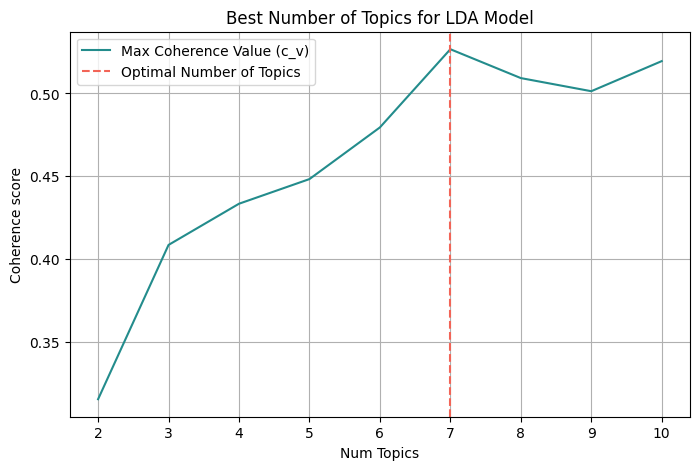

In [ ]:
topics = df['Topics']
coherence_scores = df['Coherence']

# Group coherence scores by topics and find maximum for each topic
max_coherence_scores = df.groupby('Topics')['Coherence'].max()

# Extract topics and corresponding maximum coherence scores
topics = max_coherence_scores.index
coherence_scores = max_coherence_scores.values

plt.figure(figsize=(8, 5))

# Build the line plot
ax = sns.lineplot(x=topics, y=coherence_scores, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

# Find the index of the maximum coherence score
optimal_index = np.argmax(coherence_scores)

# Add a vertical line to show the optimum number of topics
plt.axvline(topics[optimal_index], color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C',
                          ls='-', label='Max Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457',
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper left')

plt.grid(True)
plt.savefig('2024-03-07_coherence_plot_trigrams.png')
plt.show()

We can see that the Coherence Value reaches a maximum at 7 topics.

In [ ]:
# Group the DataFrame by 'Topics' and find the index of the maximum coherence score for each group
max_indices = df.groupby('Topics')['Coherence'].idxmax()

# Use the index to retrieve the corresponding rows from the DataFrame
rows_with_max_coherence = df.loc[max_indices]

# Print or return the resulting DataFrame
rows_with_max_coherence

,Validation_Set,Topics,Alpha,Beta,Coherence
8,75% Corpus,2,0.31,0.9099999999999999,0.315519
56,75% Corpus,3,asymmetric,0.31,0.408616
83,75% Corpus,4,symmetric,0.9099999999999999,0.433470
117,75% Corpus,5,asymmetric,0.61,0.448343
418,100% Corpus,6,asymmetric,0.9099999999999999,0.479521
177,75% Corpus,7,asymmetric,0.61,0.526700
453,100% Corpus,8,0.01,0.9099999999999999,0.509285
239,75% Corpus,9,asymmetric,symmetric,0.501369
258,75% Corpus,10,0.9099999999999999,0.9099999999999999,0.519518


In [ ]:
# Filter for rows where the 'Topics' column has a value of 7
selected_rows = df.loc[df['Topics'] == 7]

# Sort the selected rows by 'Coherence' in descending order
sorted_rows = selected_rows.sort_values(by='Coherence', ascending=False)

# Return the resulting DataFrame
sorted_rows

,Validation_Set,Topics,Alpha,Beta,Coherence
177,75% Corpus,7,asymmetric,0.61,0.526700
173,75% Corpus,7,symmetric,0.9099999999999999,0.486899
152,75% Corpus,7,0.01,0.61,0.485290
153,75% Corpus,7,0.01,0.9099999999999999,0.477444
158,75% Corpus,7,0.31,0.9099999999999999,0.473716
176,75% Corpus,7,asymmetric,0.31,0.456513
179,75% Corpus,7,asymmetric,symmetric,0.455803
448,100% Corpus,7,asymmetric,0.9099999999999999,0.455717
157,75% Corpus,7,0.31,0.61,0.449663
172,75% Corpus,7,symmetric,0.61,0.448953


The coherence score seems to keep increasing with the number of topics, we will choose the model that gave the highest CV before flattening out or a major drop, and the optimal alpha and beta parameters.

We will retrain the model with the following parameters:

K=7

alpha=asymmetric

beta=0.61



In [ ]:
num_topics = 7

lda_model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    random_state=100,
                    chunksize=100,
                    passes=10,
                    alpha='asymmetric',
                    eta=0.61)

In [ ]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)

with open('2024-03-07_ldavis_tuned.pickle', 'wb') as f:
  pickle.dump(vis, f)

In [ ]:
with open('2024-03-07_ldavis_tuned.pickle', 'rb') as f:
    vis = pickle.load(f)

pyLDAvis.save_html(vis, '2024-03-07_ldavis_tuned.html')

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.223316  0.030999       1        1  35.885620
2     -0.006217 -0.178907       2        1  29.650452
1      0.067410  0.019783       3        1  13.672126
3      0.030700  0.087754       4        1   7.865170
4      0.046301  0.016387       5        1   4.815032
5      0.042902  0.016549       6        1   4.187551
6      0.042220  0.007436       7        1   3.924051, topic_info=                         Term         Freq        Total Category  logprob  \
4                    covid-19  1152.000000  1152.000000  Default  30.0000   
187                      drug   167.000000   167.000000  Default  29.0000   
16                 sars-cov-2   451.000000   451.000000  Default  28.0000   
77                 inhibitors   249.000000   249.000000  Default  27.0000   
362                     human   237.000000   237.000000  Default  26.0000   
...                       ...          ...          ...      ...      ...   
71                   entities     3.718857     8.176421   Topic7  -6.9075   
11987       prefrontal_cortex     3.282183     6.901793   Topic7  -7.0324   
6214    antibiotic_resistance     3.746790    11.518472   Topic7  -6.9000   
11641  alzheimer_disease_risk     3.396386    10.246589   Topic7  -6.9982   
7552          deep_generative     3.452629    16.896649   Topic7  -6.9818   

       loglift  
4      30.0000  
187    29.0000  
16     28.0000  
77     27.0000  
362    26.0000  
...        ...  
71      2.4502  
11987   2.4948  
6214    2.1150  
11641   2.1338  
7552    1.6501  

[311 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1267       1  0.052219        3d
1267       2  0.052219        3d
1267       5  0.887720        3d
4339       1  0.190365  abnormal
4339       2  0.190365  abnormal
...      ...       ...       ...
11932      2  0.052471    volume
11932      4  0.839533    volume
5621       1  0.038396     yeast
5621       2  0.038396     yeast
5621       3  0.883115     yeast

[778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5, 6, 7])

Again we get overlapping bubbles clustering in one quadrant indicating that we are still above the optimal number of topics so we will retrain the model again with 5 topics.





In [ ]:
num_topics = 5

lda_model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    random_state=100,
                    chunksize=100,
                    passes=10,
                    alpha='asymmetric',
                    eta=0.61)

In [ ]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)

with open('2024-03-07_ldavis_tuned_v2.pickle', 'wb') as f:
  pickle.dump(vis, f)

In [ ]:
with open('2024-03-07_ldavis_tuned_v2.pickle', 'rb') as f:
    vis = pickle.load(f)

pyLDAvis.save_html(vis, '2024-03-07_ldavis_tuned_v2.html')

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.204037 -0.046839       1        1  41.152101
2     -0.004904  0.144000       2        1  27.266812
1      0.051327  0.006242       3        1  10.808982
3      0.084313 -0.144525       4        1  10.741481
4      0.073301  0.041123       5        1  10.030623, topic_info=                    Term         Freq        Total Category  logprob  loglift
4               covid-19  1261.000000  1261.000000  Default  30.0000  30.0000
2330   alzheimer_disease   228.000000   228.000000  Default  29.0000  29.0000
186              disease   144.000000   144.000000  Default  28.0000  28.0000
77            inhibitors   241.000000   241.000000  Default  27.0000  27.0000
1212            clinical   132.000000   132.000000  Default  26.0000  26.0000
...                  ...          ...          ...      ...      ...      ...
15339            neurons    14.243004    17.007617   Topic5  -6.5032   2.1221
571           inhibition    34.793120   108.370368   Topic5  -5.6100   1.1634
362                human    37.070364   267.785747   Topic5  -5.5466   0.3222
1398             effects    25.807001   104.117169   Topic5  -5.9088   0.9047
1101            response    19.336191    63.705788   Topic5  -6.1975   1.1072

[237 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1001      1  0.034385         activation
1001      2  0.034385         activation
1001      5  0.928408         activation
1170      2  0.976791         activities
449       1  0.005771           activity
...     ...       ...                ...
221       1  0.010177  virtual_screening
221       2  0.976956  virtual_screening
5621      1  0.085989              yeast
5621      2  0.042995              yeast
5621      5  0.859895              yeast

[553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

Only two topics overlap this time, so we will retrain the model a final time with 4 topics.

## 11. Final run and visualisation of results

We will retrain with k=4 and change the alpha and beta parameters from asymmetric and 0.61 to
symmetric and	0.91 respectively to reflect the optimal parameters for num_topics=4 as shown in the hyperparameter tuning results DataFrame.

In [ ]:
num_topics = 4

lda_model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    random_state=100,
                    chunksize=100,
                    passes=10,
                    alpha='symmetric',
                    eta=0.91)

In [ ]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)

with open('2024-03-07_ldavis_tuned_v3.pickle', 'wb') as f:
  pickle.dump(vis, f)

In [ ]:
with open('2024-03-07_ldavis_tuned_v3.pickle', 'rb') as f:
    vis = pickle.load(f)

pyLDAvis.save_html(vis, '2024-03-07_ldavis_tuned_v3.html')

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.046107  0.130504       1        1  37.516022
1      0.159535 -0.021798       2        1  34.485368
0     -0.083430 -0.116666       3        1  18.757616
3     -0.029997  0.007961       4        1   9.240994, topic_info=             Term         Freq        Total Category  logprob  loglift
4        covid-19  1000.000000  1000.000000  Default  30.0000  30.0000
16     sars-cov-2   442.000000   442.000000  Default  29.0000  29.0000
14      potential   325.000000   325.000000  Default  28.0000  28.0000
103    prediction   110.000000   110.000000  Default  27.0000  27.0000
896          data   221.000000   221.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
3068  statistical     9.475040    15.632658   Topic4  -6.8288   1.8808
4122    reactions     8.068553    13.464286   Topic4  -6.9895   1.8695
3582          map     9.749239    19.123274   Topic4  -6.8003   1.7078
6645        score     6.942244    16.047118   Topic4  -7.1398   1.5436
1005      surface     6.681223    19.834533   Topic4  -7.1782   1.2934

[206 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1170      1  0.054275         activities
1170      2  0.054275         activities
1170      4  0.868403         activities
449       1  0.985739           activity
449       2  0.006123           activity
...     ...       ...                ...
233       1  0.015202                use
233       2  0.972929                use
221       1  0.968915  virtual_screening
221       2  0.021773  virtual_screening
221       4  0.010887  virtual_screening

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

After running several iterations we can see that the  Intertopic Distance Map is optimal when the `num_topics` parameter is set to 4. The bubbles no longer overlap and are quite far apart so this is a good model.





## 12. Topic wordclouds

We will visualise the four topics as wordclouds containing the top 30 terms in each topic.

In [ ]:
# Get the topics from the LDA model
topics = lda_model.show_topics(num_topics=4, num_words=len(id2word), formatted=False)

# Initialise an empty list to store the words for each topic
topic_words = []

# Iterate through each topic and extract the words
for topic in topics:
    # Extract the words for the current topic and join them into a single string
    words = ', '.join([word[0] for word in topic[1]])
    # Append the words to the list
    topic_words.append(words)

# Create a DataFrame from the list of topic words
topic_row_df = pd.DataFrame(topic_words, columns=['Terms per Topic'], index=[f'Topic_{i+1}' for i in range(len(topic_words))])

# Display the DataFrame
topic_row_df

,Terms per Topic
Topic_1,"alzheimer_disease, brain, in_alzheimer_disease..."
Topic_2,"covid-19, data, analysis, clinical, drug, trea..."
Topic_3,"sars-cov-2, potential, inhibitors, protein, ta..."
Topic_4,"prediction, synthesis, synthetic, species, pro..."


In [ ]:
with open('2024-03-07_topic_row.pickle', 'wb') as f:
  pickle.dump(topic_row_df, f)

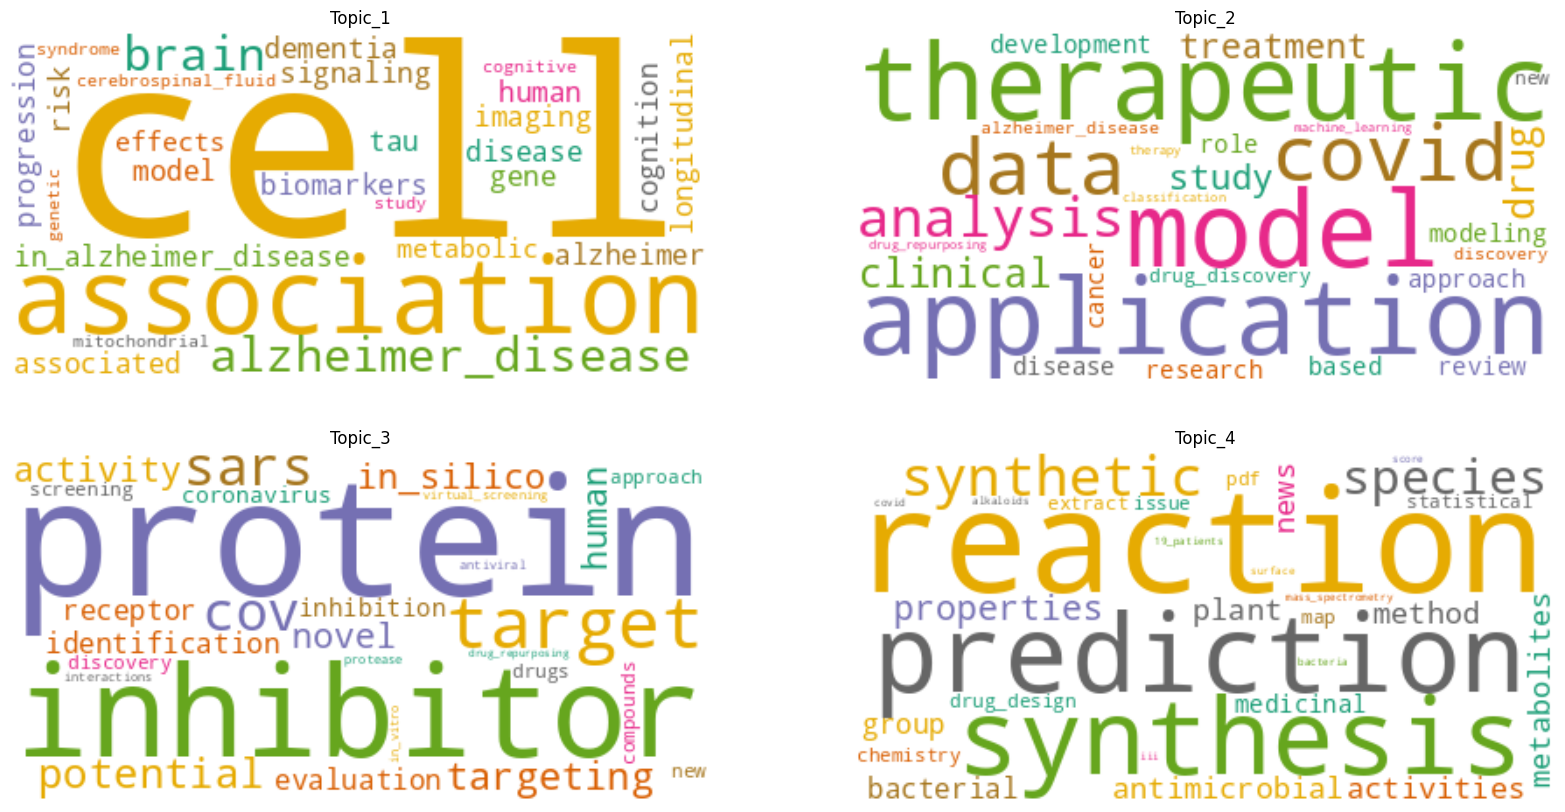

In [ ]:
# initiate wordcloud object
wordcloud = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 10]

# Create subplots for each topic
for i in range(4):
    wordcloud.generate(text=' '.join(topic_row_df["Terms per Topic"][i].split()[:30]))

    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(topic_row_df.index[i])

plt.savefig('topic_wordclouds_trigrams.png')

plt.show()

### References

* https://www.dataknowsall.com/topicmodels.html

* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

* https://www.kaggle.com/code/trnduythanhkhttt/lda-and-topic-coherence-score

* https://www.dataknowsall.com/topicmodels.html

* https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

* https://www.red-gate.com/simple-talk/databases/sql-server/bi-sql-server/deeper-insights-topic-modeling/

* https://www.kate-wolfe.com/holdshelves

* https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396

* Bengfort, B. et al. (2018). [Applied Text Analysis with Python](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/)